In [1]:
'''
This script is to train a random forest model with real and generated cells, and test it's AUC in the test set of generated cells
Be careful to change all the path that appear to your own
'''

In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import matplotlib
matplotlib.rcParams['axes.unicode_minus']=False
import seaborn as sns
sns.set(font= "Kaiti",style="ticks",font_scale=1.4)
import pandas as pd
pd.set_option("max_colwidth", 200)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,label_binarize
from sklearn.model_selection import  train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *

import warnings
warnings.filterwarnings("ignore")
import scanpy as sc
import anndata as ad
import torch
import sys
sys.path.append('..')
from VAE.VAE_model import VAE

In [2]:
def load_VAE():
    autoencoder = VAE(
        num_genes=13431,
        device='cuda',
        seed=0,
        loss_ae='mse',
        hidden_dim=128,
        decoder_activation='ReLU',
    )
    autoencoder.load_state_dict(torch.load('/data1/lep/Workspace/scDiffusion/output/checkpoint/AE/open_problem/model_seed=0_step=150000.pt'))
    return autoencoder

real data

In [24]:
adata = sc.read_h5ad('/stor/lep/diffusion/multiome/openproblems_RNA_new.h5ad')
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_cells(adata, min_genes=10)
adata.var_names_make_unique()
print(adata)

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

cell_data = adata.X.toarray()[::6]

cell_data.shape

AnnData object with n_obs × n_vars = 69249 × 13431
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'GEX_X_umap1', 'GEX_X_umap2', 'n_genes'
    var: 'feature_types', 'gene_id', 'n_cells'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'


(11542, 13431)

generated data

In [25]:
npzfile=np.load('/data1/lep/Workspace/scDiffusion/output/simulated_samples/open_problem.npz',allow_pickle=True)
cell_gen_all = npzfile['cell_gen'][:11500]#.squeeze(1)
print(cell_gen_all.shape)


autoencoder = load_VAE()
cell_gen_all = autoencoder(torch.tensor(cell_gen_all).cuda(),return_decoded=True).cpu().detach().numpy()#[:11400]
ori = ad.AnnData(cell_gen_all, dtype=np.float32)

cell_gen = ori.X#[:3000]
cell_gen.shape

(11500, 128)


(11500, 13431)

In [26]:
# back to anndata
full_data = np.concatenate((cell_data, cell_gen),axis=0)
full_data = ad.AnnData(full_data, dtype=np.float32)
full_data.obs_names = [f"true_Cell" for i in range(cell_data.shape[0])]+[f"gen_Cell" for i in range(cell_gen.shape[0])]

In [27]:
adata = full_data
sc.tl.pca(adata, svd_solver='arpack')# svd_solver 

In [28]:
real = adata[adata.obs_names=='true_Cell'].obsm['X_pca']
sim = adata[adata.obs_names=='gen_Cell'].obsm['X_pca']

data = np.concatenate((real,sim),axis=0)
label = np.concatenate((np.ones((real.shape[0])),np.zeros((sim.shape[0]))))

print(data.shape, label.shape)
##split the data
X_train,X_val,y_train,y_val = train_test_split(data, label,
                                               test_size = 0.25,random_state = 1)

print("X_train.shape :",X_train.shape)
print("X_val.shape :",X_val.shape)

(23042, 50) (23042,)
X_train.shape : (17281, 50)
X_val.shape : (5761, 50)


In [29]:
## use random forest to classify the real data and generated data
rfc1 = RandomForestClassifier(n_estimators = 1000, 
                              max_depth= 5,      
                              oob_score=True,
                              class_weight = "balanced",
                              random_state=1)
rfc1.fit(X_train,y_train)
## accuracy
rfc1_lab = rfc1.predict(X_train)
rfc1_pre = rfc1.predict(X_val)
print("OOB score of random forest:",rfc1.oob_score_)
print("accuracy in training set:",accuracy_score(y_train,rfc1_lab))
print("accuracy in validation set:",accuracy_score(y_val,rfc1_pre))

OOB score of random forest: 0.801342514900758
accuracy in training set: 0.8181818181818182
accuracy in validation set: 0.7927443152230516


plot ROC curve

findfont: Font family 'Kaiti' not found.
findfont: Font family 'Kaiti' not found.
findfont: Font family 'Kaiti' not found.
findfont: Font family 'Kaiti' not found.
findfont: Font family 'Kaiti' not found.
findfont: Font family 'Kaiti' not found.
findfont: Font family 'Kaiti' not found.
findfont: Font family 'Kaiti' not found.
findfont: Font family 'Kaiti' not found.
findfont: Font family 'Kaiti' not found.
findfont: Font family 'Kaiti' not found.
findfont: Font family 'Kaiti' not found.
findfont: Font family 'Kaiti' not found.
findfont: Font family 'Kaiti' not found.
findfont: Font family 'Kaiti' not found.
findfont: Font family 'Kaiti' not found.
findfont: Font family 'Kaiti' not found.
findfont: Font family 'Kaiti' not found.
findfont: Font family 'Kaiti' not found.
findfont: Font family 'Kaiti' not found.
findfont: Font family 'Kaiti' not found.
findfont: Font family 'Kaiti' not found.
findfont: Font family 'Kaiti' not found.
findfont: Font family 'Kaiti' not found.
findfont: Font f

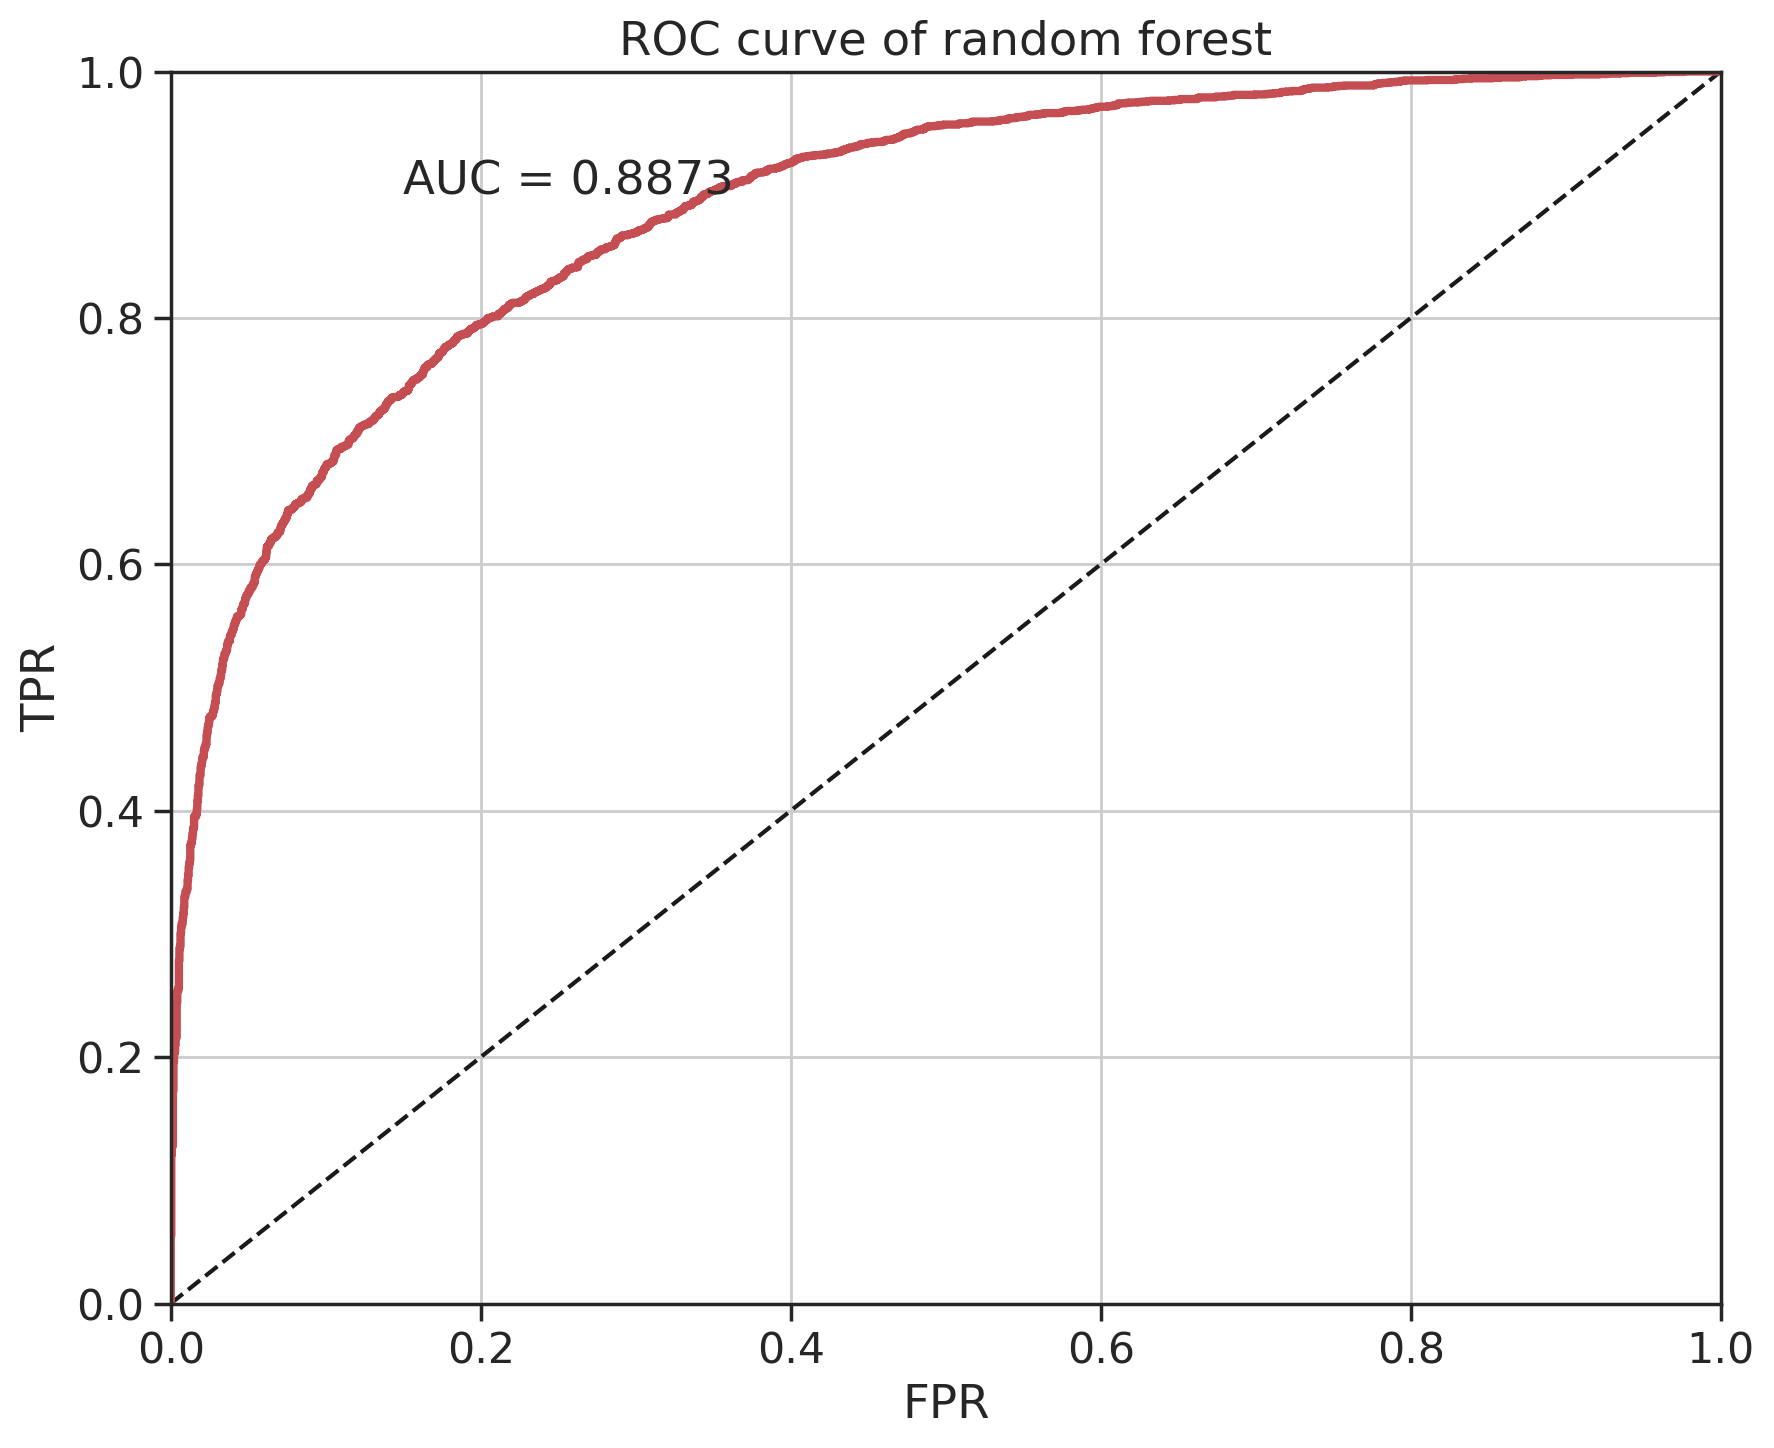

In [30]:
pre_y = rfc1.predict_proba(X_val)[:, 1]
fpr_Nb, tpr_Nb, _ = roc_curve(y_val, pre_y)
aucval = auc(fpr_Nb, tpr_Nb)    # 计算auc的取值
plt.figure(figsize=(10,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_Nb, tpr_Nb,"r",linewidth = 3)
plt.grid()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title("ROC curve of random forest")
plt.text(0.15,0.9,"AUC = "+str(round(aucval,4)))
plt.show()